# IEOR4571 Final Project: Content-Based Model


Team members: Diyue Gu (dg3198), Jingyan Xu (jx2424), Yifei Zhang (yz3925), Chelsea Cui (ac4788), Yishi Wang (yw3619)


## Content-Based Model

content-based recommendations leverage information about the content of the items that are recommended; they do not leverage any information about what other users like or consume.

In our model, we choose to do preprocessing and feature extraction (content analyzer) to build a vector-space representation of each movies based on the genre information.



## Import Packages


Python packages needed for modeling and data manipulation are imported here.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

from math import sqrt

import numpy as np
import pandas as pd
import random

import wordcloud
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

## Import Data

In [ ]:
movies_df = pd.read_csv('ml-latest/movies.csv', sep=',', header=0)

In [ ]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Extract Genres to build movie profile

The genres variable will surely be important while building the recommendation engines since it describes the content of the film (i.e. Animation, Horror, Sci-Fi). A basic assumption is that films in the same genre should have similar contents. I'll attempt to see exactly which genres are the most popular.

In [ ]:
# find all genres
genre = []
for i in movies_df['genres'].str.split('|').values:
  genre += i

In [ ]:
genre_dict = {}
for i in genre:
  genre_dict[i] = genre_dict.get(i, 0) + 1
  
sorted_genre = sorted(genre_dict.items(), key=lambda kv: kv[1], reverse = True)
print(sorted_genre)
# Top 5 genre is Drama, Comedy, Thriller, Romance, Action

[('Drama', 24144), ('Comedy', 15956), ('Thriller', 8216), ('Romance', 7412), ('Action', 7130), ('Horror', 5555), ('Documentary', 5118), ('Crime', 5105), ('(no genres listed)', 4266), ('Adventure', 4067), ('Sci-Fi', 3444), ('Mystery', 2773), ('Children', 2749), ('Animation', 2663), ('Fantasy', 2637), ('War', 1820), ('Western', 1378), ('Musical', 1113), ('Film-Noir', 364), ('IMAX', 197)]


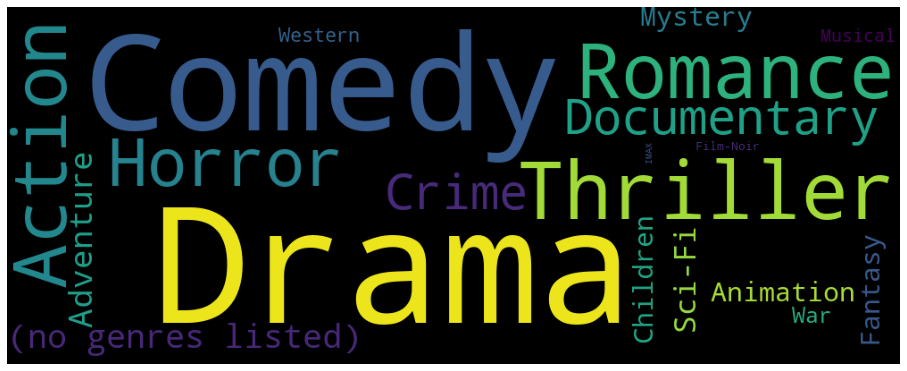

In [ ]:
# Create the wordcloud
genre_wc = WordCloud(width=1000,height=400)
genre_wc.generate_from_frequencies(genre_dict)

plt.subplots(figsize=(16, 8))
plt.imshow(genre_wc)
plt.axis('off')
plt.show()

We can have a clear overview of genres' distribution by the genres wordcloud. From this wordcloud graph we can see that the most three popular genres in our movies dataset is Drama, Comedy, and Thriller.

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/4571/final/train.csv', sep=',', header=0)
train_data.shape

(717780, 4)

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/4571/final/test_for_content.csv', sep=',', header=0)
test_data.shape

(39196, 4)

In [ ]:
top_n = 10

In [ ]:
len(test_data.userId.unique())

10344

## Content-Based Models

### TF-IDF

In information retrieval, tf–idf, TF*IDF, or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. 

It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf.

Variations of the tf–idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query. tf–idf can be successfully used for stop-words filtering in various subject fields, including text summarization and classification.

One of the simplest ranking functions is computed by summing the tf–idf for each query term; many more sophisticated ranking functions are variants of this simple model.

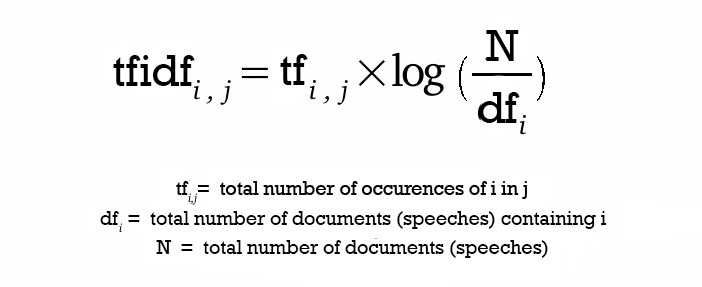

reference: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

### Cosine similarity

We use the Cosine similarity to measure the similarity of movies based on their genres vector (tf-idf) and then give recommendation.

To measure how similar two words are, we need a way to measure the degree of similarity between two embedding vectors for the two words. Given two vectors $u$ and $v$, cosine similarity is defined as follows: 

$$\text{CosineSimilarity(u, v)} = \frac {u . v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

where $u.v$ is the dot product (or inner product) of two vectors, $||u||_2$ is the norm (or length) of the vector $u$, and $\theta$ is the angle between $u$ and $v$. This similarity depends on the angle between $u$ and $v$. If $u$ and $v$ are very similar, their cosine similarity will be close to 1; if they are dissimilar, the cosine similarity will take a smaller value. 

<img src="https://github.com/wronnyhuang/word_embed_demo/blob/master/images/cosine_sim.png?raw=1" style="width:800px;height:250px;">
<caption><center> **Figure 1**: The cosine of the angle between two vectors is a measure of how similar they are</center></caption>

**Exercise**: Implement the function `cosine_similarity()` to evaluate similarity between word vectors.

**Reminder**: The norm of $u$ is defined as $ ||u||_2 = \sqrt{\sum_{i=1}^{n} u_i^2}$

reference: https://colab.research.google.com/github/wronnyhuang/word_embed_demo/blob/master/Operations%20on%20word%20vectors%20-%20v2%20-%20solutions.ipynb#scrollTo=zSjeyDrSeH1v

In [ ]:
def content_based(train_data, test_data, top_n):
  cnt = 0
  # parse movies genres
  movies_df['genres'] = movies_df['genres'].str.split('|').fillna("").astype('str')
  
  # merge movies genre with train data
  movie_train = movies_df[movies_df['movieId'].isin(train_data['movieId'])]
  
  # build movie profile based on genre
  tfvec = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), stop_words='english')
  genre_tfidf_matrix = tfvec.fit_transform(movie_train['genres'])
  genre_tfidf_matrix = genre_tfidf_matrix.todense()
  genre_df = pd.DataFrame(genre_tfidf_matrix)
  genre_df.insert(loc = 0, column = 'movieId', value = movie_train['movieId'].tolist())
  genre_df.set_index('movieId', inplace = True)
  
  # compute weight
  train_data['sum_weight'] = train_data.groupby('userId')['rating'].transform(lambda x: x.sum())
  train_data['weight'] = train_data['rating'] / train_data['sum_weight']
  
  # build user profile
  weighted_genre_user = {}
  for user in train_data.userId.unique():
    weight = train_data[train_data['userId'] == user]['weight']
    movie = train_data[train_data['userId'] == user]['movieId'].values.tolist()
    new_genre = np.transpose(genre_df[genre_df.index.isin(movie)].values).dot(weight.values.reshape(-1, 1))
    new_genre = [item for elem in new_genre for item in elem]
    weighted_genre_user[user] = new_genre
  genre_user = pd.DataFrame(weighted_genre_user).T
  genre_movie = genre_df

  # make recommendation for test_data
  recommend = pd.DataFrame(data = None, columns = ['userId', 'Recommendation']) 
  for userID in test_data.userId.unique():
    cnt += 1
    if cnt % 100 == 0:
      print(cnt)
    result = []
    for idx in genre_movie.index:
        cos_sim = cosine_similarity([genre_movie.loc[idx].tolist()], [genre_user.loc[userID].tolist()])
        result.append((idx, cos_sim.item((0, 0)))) 
    recommendation = [(item[0], item[1] * 5) for item in sorted(result, key = lambda x: x[1], reverse= True)[:top_n]]
    new_row = {'userId': userID, 'Recommendation': recommendation}
    recommend = recommend.append(new_row, ignore_index=True)
  return recommend

In [ ]:
recommend =  content_based(train_data, test_data, 10)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300


In [ ]:
recommend.to_csv("/content/drive/MyDrive/4571/final/content_based_recommend_df.csv")

In [ ]:
recommend.shape

(10344, 2)

In [ ]:

def recommend_single_user(single_userId):
  return recommend[recommend['userId'] == single_userId][['Recommendation']].values.tolist()

In [ ]:
recommend_single_user(128776)

[[(1127, 3.2176592835985667),
  (1129, 3.2176592835985667),
  (1374, 3.2176592835985667),
  (5349, 3.2176592835985667),
  (8644, 3.2176592835985667),
  (34048, 3.2176592835985667),
  (61248, 3.2176592835985667),
  (70336, 3.2176592835985667),
  (120799, 3.2176592835985667),
  (122882, 3.2176592835985667)]]

# Evaluation

In [ ]:
recommendation_user(34, 5)

[(84730, 3.537151428883587),
 (116797, 3.537151428883587),
 (174645, 3.537151428883587),
 (2617, 3.237115806651202),
 (56093, 3.227087071290774)]

In [ ]:
train_data[train_data['userId'] == 34]

,userId,movieId,rating,timestamp,sum_weight,weight
2265,34,116797,2.5,1472946511,13.5,0.185185
2210,34,2617,4.5,1472945490,13.5,0.333333
2240,34,51255,1.5,1472945925,13.5,0.111111
2203,34,1653,5.0,1472945452,13.5,0.370370


In [ ]:
def content_based_rmse(train_data, userId):
  def predict(train_data, userId):
    list_movie = train_data[train_data['userId'] == userId]['movieId'].values.tolist()
    pred_ratings = []
    for movie in list_movie:
      rating = float(cosine_similarity([genre_movie.loc[movie].tolist()], [genre_user.loc[userId].tolist()]) * 5)
      pred_ratings.append(rating)
    return pred_ratings

  pred_ratings = predict(train_data, userId)
  actual_ratings = train_data[train_data['userId'] == userId]['rating'].values.tolist()
  rmse = mean_squared_error(pred_ratings, actual_ratings) ** 0.5
  return rmse

In [ ]:
def content_based_precision_k(train_data, userId, k, top_n):
  recommend_movies = recommendation_user(userId, top_n)
  ds = pd.DataFrame(data = None, columns = ['movieId', 'Actual_Rating', 'Predict_Rating']) 
  for movie_id, predict_rating in recommend_movies:
    if movie_id in train_data[train_data['userId'] == userId]['movieId'].values.tolist():
      new_row = {'movieId':movie_id, 'Actual_Rating': train_data.loc[(train_data['userId'] == userId) & (train_data['movieId'] == movie_id)]['rating'].values[0], 'Predict_Rating':predict_rating}
      ds = ds.append(new_row, ignore_index=True)
  relevant_items = ds.loc[ds['Actual_Rating'] >= 3.5]['movieId'].values.tolist()
  # print(relevant_items)
  predict_items = ds.sort_values(by=['Predict_Rating'], ascending = False)[:k]['movieId'].values.tolist()
  # print(predict_items)
  try:
    overlap = list(set(relevant_items) & set(predict_items)) 
    precision_k = len(overlap)/len(predict_items)
  except:
    precison_k = 0
  return precision_k

In [ ]:
def content_based_recall_k(train_data, userId, k, top_n):
  ds = pd.DataFrame(data = None, columns = ['movieId', 'Actual_Rating', 'Predict_Rating']) 
  for movie_id, predict_rating in recommend_movies:
    if movie_id in train_data[train_data['userId'] == userId]['movieId'].values.tolist():
      new_row = {'movieId':movie_id, 'Actual_Rating': train_data.loc[(train_data['userId'] == userId) & (train_data['movieId'] == movie_id)]['rating'].values[0], 'Predict_Rating':predict_rating}
      ds = ds.append(new_row, ignore_index=True)
  relevant_items = ds.loc[ds['Actual_Rating'] >= 3.5]['movieId'].values.tolist()
  # print(relevant_items)
  predict_items = ds.sort_values(by=['Predict_Rating'], ascending = False)[:k]['movieId'].values.tolist()
  # print(predict_items)
  try:
    overlap = list(set(relevant_items) & set(predict_items)) 
    recall_k = len(overlap)/len(relevant_items)
  except:
    recall_k = 0
  return recall_k

In [ ]:
# test average rmse
rmse_sum = 0
num = 0
for user in test_data['userId'].unique():
  try:
    temp = rmse(user)
    rmse_sum += temp
    num += 1
  except:
    continue
avg_rmse = rmse_sum/num
print(avg_rmse)

In [ ]:
# test precision@k
# @k = 4, top_n = 5
precision_sum = 0
num = 0
prog = 0
for user in test_data['userId'].unique():
  try:
    temp = precision_k(user, 3, 4)
    precision_sum += temp
    num += 1
  except:
    continue
average_precision = precision_sum/num
print(average_precision)

60
220
280
300
420
480
520
540
580
620
680
700
720
740
760
780
800
880
1020
1040
1060
1080
1160
1180
1220
1240
1320
1400
1440
1460
1520
1540
1560
1580
1700
1820
1840
1900
1920
2000
2060
2100
2120
2240
2280
2300
2400
2440
2500
2560
2580
2620
2660
2700
2740
2900
2940
3020
3060
3080
3140
3160
3220
3360
3460
3500
3620
3660
3680
3860
4020
4060
4120
4140
4220
4240
4260
4280
4460
4500
4820
4840
4860
4880
5040
5060
5120
5160
5280
5300
5400
5460
5480
5580
5920
5980
6000
6020
6060
6080
6140
6160
6220
6260
6300
6380
6400
6480
6520
6560
6600
6620
6700
6720
6740
6880
6900
6940
6960
6980
7040
7060
7080
7100
7200
7220
7240
7280
7300
7460
7480
7560
7620
7680
7720
7800
7880
8000
8040
8080
8100
8220
8260
8300
8320


In [ ]:
print(precision_sum/num)

0.5735716468072106


In [ ]:
recall_sum = 0
num = 0
prog = 0
for user in test_data['userId'].unique():
  try:
    temp = recall_k(user, 3, 4)
    recall_sum += temp
    num += 1
  except:
    continue
average_recall = recall_sum/num
print(average_recall)